# Simulated NISAR Access and Exploration

Authors: Rajat Shinde (UAH), Sheyenne Kirkland (UAH), Julia Signell (Element84), Alex Mandel (DevSeed), Chuck Daniels (DevSeed)

Date: September 3, 2024

Description: In this tutorial, we'll demonstrate how to access simulated NISAR (NASA-ISRO SAR Mission) data from the [MAAP STAC Catalog](https://stac-browser.maap-project.org/?.language=en). We'll use two methods to retrieve temporary S3 credentials, and xarray's `DataTree` to explore the data and create a visualization.

## Run This Notebook

To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the ["Getting started with the MAAP"](https://docs.maap-project.org/en/latest/getting_started/getting_started.html) section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP's ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors. Additionally, it is recommended to use the `Pangeo` workspace within the ADE, since certain packages relevant to this tutorial are already installed.

## About the Data

There are a set of sample products using JAXA ALOS-1 PALSAR data as a surrogate for NISAR. The sample covers the full suite of planned products, from Level 0 raw data (in NISAR format) to Level 1 and Level 2. These data cover a smaller area than a NISAR frame, but the metadata content is fully compatible with the data NISAR will produce after entering the science phase. (Source: [Data Overview](https://nisar.jpl.nasa.gov/data/overview/))

NISAR is planned to launch no earlier than February 2025.

## Additional Resources
- [NISAR](https://nisar.jpl.nasa.gov/)
- [Level-2 Geocoded Polarimetric Covariance (L2 GCOV) product specification](https://nisar.asf.earthdatacloud.nasa.gov/NISAR-SAMPLE-DATA/DOCS/NISAR_D-102274_L2_GCOV_Product_Spec_R3.4_231109_clean_w-sigs.pdf)
- [xarray Datatree](https://xarray-datatree.readthedocs.io/en/latest/)

## Import and Install Packages

The following are optional installs, as they should be included within the Pangeo workspace.

In [1]:
#!pip install -q xarray xarray-datatree

Run the following cell to import the packages necessary for this tutorial.

In [2]:
!pip install -q earthaccess

from maap.maap import MAAP
from pystac_client import Client
import xarray as xr
from datatree import open_datatree
import os
import s3fs
import earthaccess

maap = MAAP()

## Access the Data

After launch, NISAR data will be hosted at and catalogued by ASF DAAC (Alaska Satellite Facility Distributed Active Archive Center). Guidance for accessing ASF data via MAAP can be found here: https://docs.maap-project.org/en/latest/technical_tutorials/access/accessing_external_data.html#Accessing-Sentinel-1-Granule-Data-from-the-Alaska-Satellite-Facility-(ASF). In the meantime, the NISAR project has made sample NISAR simulated datasets available via https://nisar.jpl.nasa.gov/data/sample-data/. 

However, these NISAR sample products are not searchable via NASA's CMR (Common Metadata Repository). So, for the convenience of MAAP users, these simulated data products were catalogued in MAAP's data archive and can be accessed through the MAAP STAC Catalog. This will allow users to become familiar with accessing the NISAR datasets via the MAAP API and in cloud-friendly ways.

To access the Simulated NISAR data, we'll open the MAAP STAC catalog, and then use the collection ID "nisar-sim" to get our desired collection. For this example, we are interested in working with the L2 GCOV (Level-2 Geocoded Polarimetric Covariance) product and will need the S3 link for cloud access. This is all executed in the following code block.

In [3]:
catalog = 'https://stac.maap-project.org/'
client = Client.open(catalog)

for item in client.search(collections="nisar-sim").items():

  if asset := item.assets.get("GCOV"):

    s3_link = asset.extra_fields["alternate"]["href"]

    break

print(s3_link)

s3://sds-n-cumulus-prod-nisar-sample-data/GCOV/ALOS1_Rosamond_20081012/NISAR_L2_PR_GCOV_001_005_A_219_4020_SHNA_A_20081012T060910_20081012T060926_P01101_F_N_J_001.h5


Let's look at two methods that fetch temporary S3 credentials for the data from ASF.

### `maap-py`

The first method is using `maap-py`, which can only be used while working in the MAAP ADE. We'll get the temporary credentials and pass them into `s3fs`.

In [4]:
def get_s3_creds(url):
    return maap.aws.earthdata_s3_credentials(url)

def get_s3_client(s3_cred_endpoint):
    creds=get_s3_creds(s3_cred_endpoint)
    boto3_session = boto3.Session(
            aws_access_key_id=creds['accessKeyId'],
            aws_secret_access_key=creds['secretAccessKey'],
            aws_session_token=creds['sessionToken']
    )
    return boto3_session.client("s3")

asf_s3 = "https://nisar.asf.earthdatacloud.nasa.gov/s3credentials"
creds = get_s3_creds(asf_s3)

# pass credentials into s3fs
fs_s3 = s3fs.S3FileSystem(anon=False, 
                          key=creds['accessKeyId'], 
                          secret=creds['secretAccessKey'], 
                          token=creds['sessionToken'])

### `earthaccess`

The second method is through `earthaccess`. This method should be used if you are not working in the MAAP ADE. For authentication, you'll need an Earthdata login or EDL. The cell below will allow you to manually enter your username and password (keyed out) if it cannot authenticate through a .netrc file or environment variables.

For more information, see [Authentication: Before we can use earthaccess we need an account with NASA EDL](https://nasa-openscapes.github.io/earthdata-cloud-cookbook/tutorials/earthaccess-demo.html#authentication-before-we-can-use-earthaccess-we-need-an-account-with-nasa-edl).

In [ ]:
earthaccess.login()

Now that we're logged in, we can run the cell below, which slightly simplifies what we did in the code block above. This essentially bypasses the need to write the code to pull and pass temporary credentials into `s3fs`; the line below will go ahead and return an instance of `s3fs.S3FileSystem`.

In [ ]:
fs_s3 = earthaccess.__store__.get_s3fs_session(endpoint=asf_s3)

## Explore the Data

Since we retrieved our credentials and passed them into `s3fs`, we can now open our S3 url, which we pulled when accessing our item.

In [5]:
nisar_file_obj = fs_s3.open(s3_link, mode='rb')

To further explore the data and prepare for visualization we'll use xarray's `DataTree`. This package will show our data in a nice hierarchical structure that we can navigate.

In [6]:
dt = open_datatree(nisar_file_obj, engine='h5netcdf', phony_dims='sort')
dt

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       Conventions:  CF-1.8
└── DataTree('science')
    └── DataTree('LSAR')
        ├── DataTree('GCOV')
        │   ├── DataTree('grids')
        │   │   └── DataTree('frequencyA')
        │   │           Dimensions:                                   (yCoordinates: 6220,
        │   │                                                          xCoordinates: 4545,
        │   │                                                          phony_dim_2: 1)
        │   │           Coordinates:
        │   │             * xCoordinates                              (xCoordinates) float64 36kB 3.6...
        │   │             * yCoordinates                              (yCoordinates) float64 50kB 3.9...
        │   │           Dimensions without coordinates: phony_dim_2
        │   │           Data variables: (12/15)
        │   │               HHHH                                      (yCoordinates, xCoordinates) float32 113MB ...
        │   │               azimuthBandwidth                          float64 8B ...
        │   │               centerFrequency                           float64 8B ...
        │   │               listOfCovarianceTerms                     (phony_dim_2) |S4 4B ...
        │   │               listOfPolarizations                       (phony_dim_2) |S2 2B ...
        │   │               numberOfLooks                             (yCoordinates, xCoordinates) float32 113MB ...
        │   │               ...                                        ...
        │   │               rangeBandwidth                            float64 8B ...
        │   │               rtcAreaNormalizationFactorGamma0ToSigma0  (yCoordinates, xCoordinates) float32 113MB ...
        │   │               slantRangeSpacing                         float64 8B ...
        │   │               xCoordinateSpacing                        float64 8B ...
        │   │               yCoordinateSpacing                        float64 8B ...
        │   │               zeroDopplerTimeSpacing                    timedelta64[ns] 8B ...
        │   └── DataTree('metadata')
        │       ├── DataTree('attitude')
        │       │       Dimensions:          (phony_dim_3: 22, phony_dim_4: 3, phony_dim_5: 4)
        │       │       Dimensions without coordinates: phony_dim_3, phony_dim_4, phony_dim_5
        │       │       Data variables:
        │       │           angularVelocity  (phony_dim_3, phony_dim_4) float64 528B ...
        │       │           attitudeType     |S10 10B ...
        │       │           eulerAngles      (phony_dim_3, phony_dim_4) float64 528B ...
        │       │           quaternions      (phony_dim_3, phony_dim_5) float64 704B ...
        │       │           time             (phony_dim_3) datetime64[ns] 176B ...
        │       ├── DataTree('calibrationInformation')
        │       │   └── DataTree('frequencyA')
        │       │       └── DataTree('HH')
        │       │               Dimensions:                  (phony_dim_6: 611, phony_dim_7: 130)
        │       │               Dimensions without coordinates: phony_dim_6, phony_dim_7
        │       │               Data variables:
        │       │                   elevationAntennaPattern  (phony_dim_6, phony_dim_7) float32 318kB ...
        │       │                   nes0                     (phony_dim_6, phony_dim_7) float32 318kB ...
        │       │                   rfiLikelihood            float64 8B ...
        │       ├── DataTree('orbit')
        │       │       Dimensions:       (phony_dim_8: 28, phony_dim_9: 3)
        │       │       Dimensions without coordinates: phony_dim_8, phony_dim_9
        │       │       Data variables:
        │       │           acceleration  (phony_dim_8, phony_dim_9) float64 672B ...
        │       │           interpMethod  |S50 50B ...
        │       │           orbitType     |S10 10B ...
        │       │           position      (phony_

## Visualize the Data

Finally, let's visualize our data using `matplotlib` via .plot(). Given what we discovered by inspecting the DataTree above, we know that we are interested in the "frequencyA" group, which holds the "HHHH" variable.

Before plotting our data, we will transform our coordinates. By transforming our coordinates, we'll be able to plot our image using latitude and longitude instead of UTM. To access the original projection information, use `ds.projection` before reprojecting.

In [ ]:
ds = (dt["science/LSAR/GCOV/grids/frequencyA"].ds)

# manually set the CRS using embedded projection
ds.rio.write_crs(f'epsg:{ds["projection"].epsg_code}', inplace=True)

# reproject 
ds_reproj = ds.rio.reproject(4326)

Next, let's apply a gamma correction by taking the square root of our original values. While this isn't necessary, it will brighten the image, making features more visible. While plotting, we will also remove the outliers.

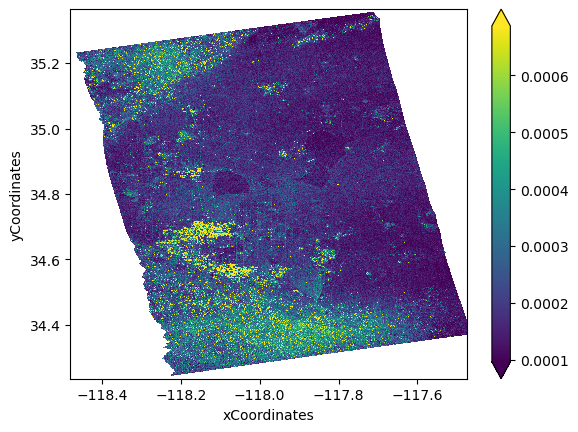

In [10]:
x_coords = ds_reproj.HHHH.coords['x'].data
y_coords = ds_reproj.HHHH.coords['y'].data

# take square root of original array values
sqrt_array = (ds_reproj.HHHH.data)**0.5

# create new data array with square root, then specify dimension names and assign values
HHHH_update = xr.DataArray(sqrt_array, dims=("yCoordinates","xCoordinates"), coords={"yCoordinates": y_coords, "xCoordinates": x_coords})

# plot
# robust = true removes outliers by using 2nd and 98th percentiles
HHHH_update.plot(robust="True")

For tutorials on visualizing the data within a GIS environment, see [Tutorials available for working with NISAR sample data](https://asf.alaska.edu/trainings/tutorials-available-for-working-with-nisar-sample-data/). 